# Visualize the results

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os, re
import util
from collections import defaultdict
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib notebook

## Plot Embeddings

In [40]:
def restore_emb(config, train_dir):
    print 'Restoring graph...',
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.all_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            embeddings = sess.run(tf.all_variables())
    print 'done.'        
    if config.has_key('contextwise') and config['contextwise']:
        return embeddings[:3]
    else:
        return embeddings[0]

In [41]:
def get_2d_emb(embeddings, limit=5000):
    print 'Reducing dimension...',
    embeddings = embeddings[:limit]
    norm = np.sqrt(np.sum(np.square(embeddings), axis=0))
    normalized_embeddings = embeddings / norm
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    two_d_embeddings = tsne.fit_transform(normalized_embeddings)
    print 'done.'
    return two_d_embeddings

In [42]:
def construct_emb_df(data_dir, two_d_embeddings):
    print 'Loading vocabulary...',
    vocab_path = os.path.join(data_dir, 'vocab.txt')
    word2id, _ = util.initialize_vocabulary(vocab_path)
    word = pd.DataFrame({'word': word2id.keys()}, index=word2id.values())
    values = pd.DataFrame(two_d_embeddings, columns=['x', 'y'])
    emb_df = pd.concat([word, values], axis=1)
    emb_df = emb_df[pd.notnull(emb_df.x)]
    print 'done.'
    return emb_df

In [43]:
def merge_id(emb_df, lower=True):
    print 'Merging ids...',
    positive_df = pd.read_csv(os.path.join(data_dir, '..', 'positive_relations.tsv'),
                           sep='\t', index_col=0, encoding='utf-8')
    subj = positive_df[['subj', 'subj_qid']].rename_axis(
        {"subj": "entity", "subj_qid": "id"}, axis="columns")
    obj = positive_df[['obj', 'obj_qid']].rename_axis(
        {"obj": "entity", "obj_qid": "id"}, axis="columns")
    rel = positive_df[['rel', 'rel_id']].rename_axis(
        {"rel_id": "id"}, axis="columns")
    entity = pd.concat([subj, obj, rel], axis=0, ignore_index=True)
    if lower:
        entity['word'] = ['<' + w.lower() + '>' for w in entity['id']]
    else:
        entity['word'] = ['<' + w + '>' for w in entity['id']]
    entity = entity.drop_duplicates('word')
    merge_emb_df = emb_df.merge(entity[['entity', 'rel', 'word']], how='outer', on='word')
    print 'done.'
    return merge_emb_df

In [44]:
def plot_emb(dfs, colors, labels, anno=None, limit=None, 
             title='Embeddings', xlim=None, ylim=None):
    ax = dfs[0].plot(kind="scatter", 
            x='x', y='y', color=colors[0], legend=True, label=labels[0])
    ax = dfs[1].plot(kind="scatter", ax=ax, 
            x='x', y='y', color=colors[1], legend=True, label=labels[1])
    # annotate labels
    if anno:
        for index, row in dfs[1].iterrows():
            if limit and index % limit != 0:
                continue
            ax.annotate(row[anno], xy=(row['x'], row['y']))
            
    ax.set_xlabel('')
    ax.set_ylabel('')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(title)
    fig = ax.get_figure()
    return fig

### MLMI-CONT

In [45]:
train_dir = os.path.join(os.getcwd(), 'train', '1474062134')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']

embeddings = restore_emb(config, train_dir)
colors = ['#E24A33', '#348ABD']
labels = ['words', 'entities']

Restoring graph... done.


Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


<IPython.core.display.Javascript object>


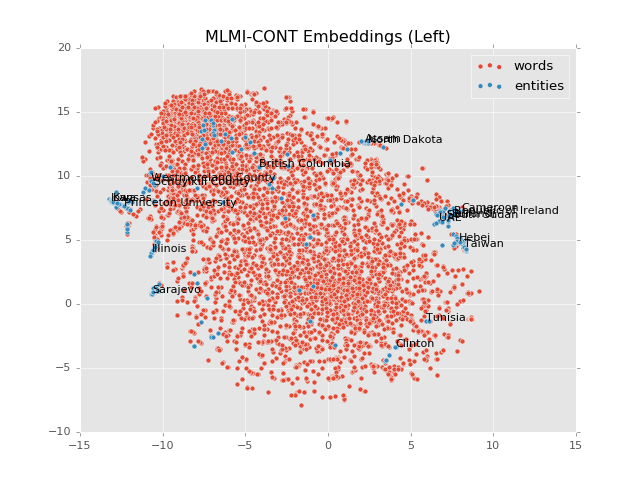

In [46]:
two_d_emb_left = get_2d_emb(embeddings[0], limit=5000)
emb_df_left = construct_emb_df(data_dir, two_d_emb_left)
emb_df_left = merge_id(emb_df_left, lower=True)
dfs_left = [emb_df_left[pd.isnull(emb_df_left.entity)], 
            emb_df_left[pd.notnull(emb_df_left.entity)]]
fig_left = plot_emb(dfs_left, colors, labels, anno='entity', limit=20,
                    title='MLMI-CONT Embeddings (Left)')
fig_left.savefig(os.path.join(train_dir, 'emb_left.pdf'))

Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


<IPython.core.display.Javascript object>


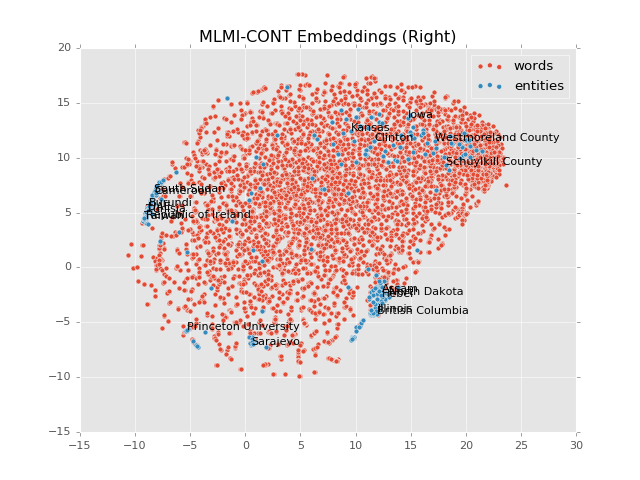

In [47]:
two_d_emb_right = get_2d_emb(embeddings[2], limit=5000)
emb_df_right = construct_emb_df(data_dir, two_d_emb_right)
emb_df_right = merge_id(emb_df_right, lower=True)
dfs_right = [emb_df_right[pd.isnull(emb_df_right.entity)], 
             emb_df_right[pd.notnull(emb_df_right.entity)]]
fig_right = plot_emb(dfs_right, colors, labels, anno='entity', limit=20,
                    title='MLMI-CONT Embeddings (Right)')
fig_right.savefig(os.path.join(train_dir, 'emb_right.pdf'))

### ER-CNN

 Restoring graph... done.
Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


<IPython.core.display.Javascript object>


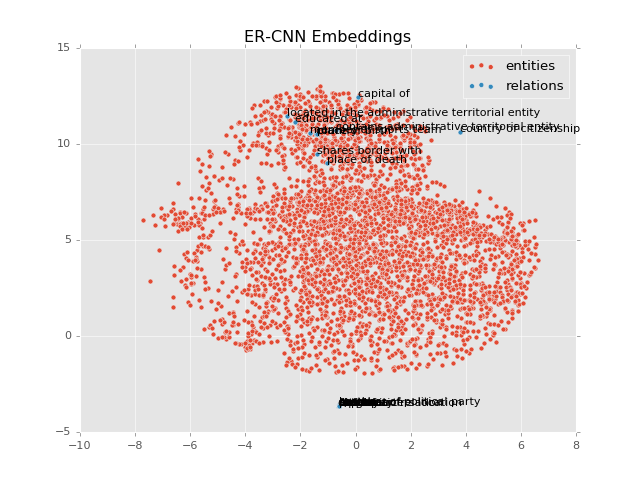

In [8]:
train_dir = os.path.join(os.getcwd(), 'train', '1474149092')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['entities', 'relations']

emb_er = restore_emb(config, train_dir)
two_d_emb_er = get_2d_emb(emb_er, limit=5000)
df_er = construct_emb_df(data_dir, two_d_emb_er)
emb_df_er = merge_id(df_er, lower=False)
dfs_er = [emb_df_er[pd.notnull(emb_df_er.entity)], 
          emb_df_er[pd.notnull(emb_df_er.rel)]]
fig_er = plot_emb(dfs_er, colors, labels, anno='rel', 
                  limit=None, title='ER-CNN Embeddings')
fig_er.savefig(os.path.join(train_dir, 'emb.pdf'))

<IPython.core.display.Javascript object>


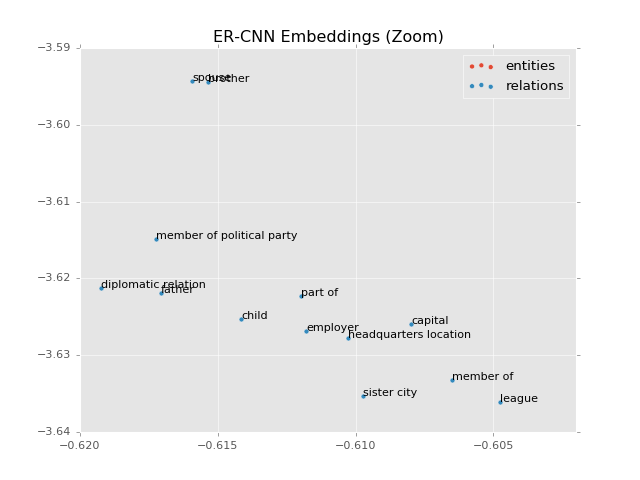

In [9]:
fig_zoom1 = plot_emb(dfs_er, colors, labels, anno='rel', 
                  limit=None, title='ER-CNN Embeddings (Zoom)', 
               xlim=(-0.62, -0.602), ylim=(-3.64, -3.59))
fig_zoom1.savefig(os.path.join(train_dir, 'emb_zoom1.pdf'))

<IPython.core.display.Javascript object>


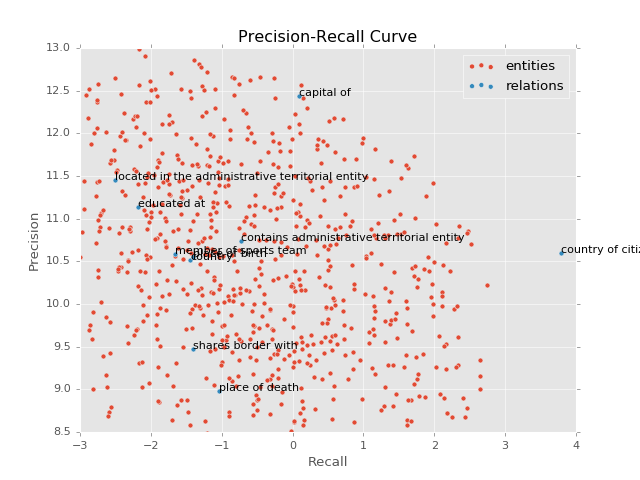

In [10]:
fig_zoom2 = plot_emb(dfs_er, colors, labels, anno='rel', 
                  limit=None, title='ER-CNN Embeddings (Zoom)', 
               xlim=(-3, 4.5), ylim=(8.5, 13))
fig_zoom2.savefig(os.path.join(train_dir, 'emb_zoom2.pdf'))

### MLMI-CNN

Restoring graph... done.
Reducing dimension... done.
Loading vocabulary... done.
Merging ids... done.


<IPython.core.display.Javascript object>


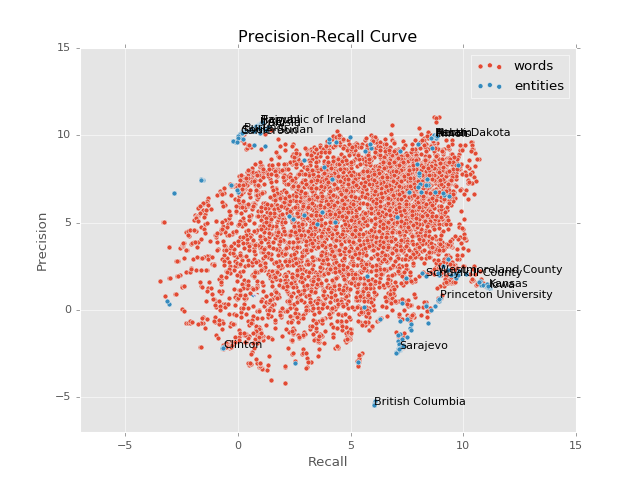

In [23]:
train_dir = os.path.join(os.getcwd(), 'train', '1474179389')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
data_dir = config['data_dir']
colors = ['#E24A33', '#348ABD']
labels = ['words', 'entities']

emb_mlmi = restore_emb(config, train_dir)
two_d_emb_mlmi = get_2d_emb(emb_mlmi, limit=5000)
df_mlmi = construct_emb_df(data_dir, two_d_emb_mlmi)
emb_df_mlmi = merge_id(df_mlmi, lower=True)
dfs_mlmi = [emb_df_mlmi[pd.isnull(emb_df_mlmi.entity)], 
            emb_df_mlmi[pd.notnull(emb_df_mlmi.entity)]]
fig_mlmi = plot_emb(dfs_mlmi, colors, labels, anno='entity', 
                    limit=20, title='MLMI-CNN Embeddings', 
                    xlim=(-7, 15), ylim=(-7, 15))
fig_mlmi.savefig(os.path.join(train_dir, 'emb.pdf'))

## Plot Precision-Recall Curve

In [52]:
def plot_pr_curve(train_dirs, colors, labels, xlim=None, ylim=None):
    
    for i, train_dir in enumerate(train_dirs):
        results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
        plt.plot(results['recall'], results['precision'], 'o-', 
                 color=colors[i], label=labels[i])
        
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower right')
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.savefig(os.path.join(os.getcwd(), 'train', 'pr_curve.pdf'))

<IPython.core.display.Javascript object>


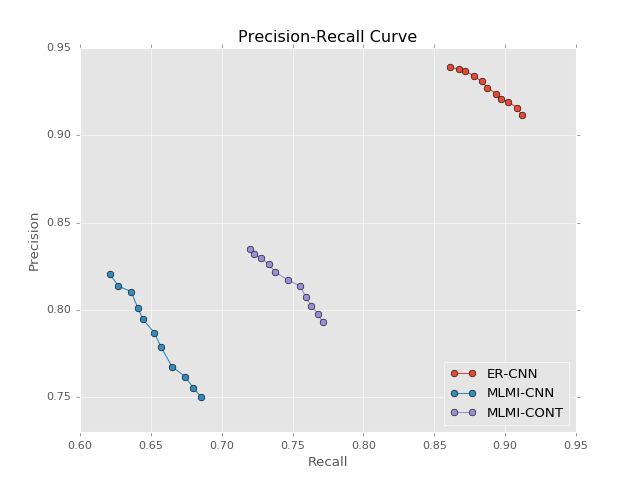

In [53]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
colors = ['#E24A33', '#348ABD', '#988ED5']
labels = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_pr_curve(train_dirs, colors, labels, ylim=(0.73, 0.95))

In [38]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
for i, train_dir in enumerate(train_dirs):
    results = util.load_from_dump(os.path.join(train_dir, 'results.cPickle'))
    pre = results['precision'][5]
    rec = results['recall'][5]
    f1 = (2.0 * pre * rec) / (pre + rec)
    auc = util.calc_auc_pr(results['precision'], results['recall'])
    print '%9s  %.2f  %.2f  %.2f  %.2f' % (models[i], pre, rec, f1, auc)

   ER-CNN  0.93  0.89  0.91  0.92
 MLMI-CNN  0.79  0.65  0.71  0.73
MLMI-CONT  0.82  0.75  0.78  0.79


In [11]:
def get_scores(config, data, train_dir):
    with tf.Graph().as_default():
        with tf.variable_scope('cnn'):
            if config.has_key('contextwise') and config['contextwise']:
                import cnn_context
                m = cnn_context.Model(config, is_train=False)
            else:
                import cnn
                m = cnn.Model(config, is_train=False)
        saver = tf.train.Saver(tf.all_variables())

        with tf.Session() as sess:
            ckpt = tf.train.get_checkpoint_state(train_dir)
            saver.restore(sess, ckpt.model_checkpoint_path)
            
            predictions = []
            batches = util.batch_iter(data, batch_size=config['batch_size'], num_epochs=1, shuffle=False)
            for batch in batches:
                if config.has_key('contextwise') and config['contextwise']:
                    left_batch, middle_batch, right_batch, y_batch, _ = zip(*batch)
                    feed = {m.left: np.array(left_batch),
                            m.middle: np.array(middle_batch),
                            m.right: np.array(right_batch),
                            m.labels: np.array(y_batch)}
                else:
                    x_batch, y_batch, _ = zip(*batch)
                    feed = {m.inputs: np.array(x_batch), m.labels: np.array(y_batch)}
                prob = sess.run(m.scores, feed_dict=feed)
                prediction = tf.select(prob > 0.5, tf.ones_like(prob), tf.zeros_like(prob))
                predictions.extend(prediction.eval())
            
    return np.array(predictions)

In [35]:
def report(y_true, y_pred, class_names):
    tp = np.logical_and(y_true, y_pred)
    fp = np.logical_and(np.logical_not(y_true), y_pred)
    fn = np.logical_and(y_true, np.logical_not(y_pred))
    pre = np.sum(tp.astype(float), axis=0) / np.sum(np.logical_or(tp, fp).astype(float), axis=0)
    rec = np.sum(tp.astype(float), axis=0) / np.sum(np.logical_or(tp, fn).astype(float), axis=0)
    f1 = (2.0 * pre * rec) / (pre + rec)
    count = np.sum(y_pred, axis=0)
    print '          P \t  R \t  F \t  C'
    for c, p, r, f, s in zip(class_names, pre, rec, f1, count):
        print '%6s\t%.4f\t%.4f\t%.4f\t%4d' % (c, p, r, f, s)
        
    print '%6s\t%.4f\t%.4f\t%.4f\t%4d' % ('total', 
                                     np.sum(pre[np.isfinite(pre)]*count[np.isfinite(pre)])/count.sum(dtype=float), 
                                     np.sum(rec[np.isfinite(rec)]*count[np.isfinite(rec)])/count.sum(dtype=float), 
                                     np.sum(f1[np.isfinite(f1)]*count[np.isfinite(f1)])/count.sum(dtype=float), 
                                     count.sum())

In [3]:
class_names = [u'P17', u'P131', u'P27', u'P47', u'P19', u'P150', u'P54', u'P20', 
               u'P1376', u'P69', u'P159', u'P530', u'P108', u'P26', u'P118', 
               u'P40', u'P36', u'P102', u'P361', u'P463', u'P190', u'P22', u'P7']

In [111]:
train_dir = os.path.join(os.getcwd(), 'train', '1474179389')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids.txt")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data(source_path, target_path, config['sent_len'],
                         train_size=config['train_size'])

y_true = np.array([y[1] for y in data])
y_pred = get_scores(config, data, train_dir)
print classification_report(y_true, y_pred, target_names=class_names)

             precision    recall  f1-score   support

        P17       0.81      0.87      0.84       651
       P131       0.85      0.77      0.81       488
        P27       0.89      0.40      0.55       160
        P47       0.76      0.80      0.78       225
        P19       0.75      0.21      0.33        56
       P150       0.57      0.40      0.47        75
        P54       0.79      0.81      0.80        27
        P20       0.46      0.23      0.31        26
      P1376       0.86      0.32      0.46        57
        P69       0.00      0.00      0.00        22
       P159       0.80      0.34      0.48        35
       P530       0.46      0.63      0.53        49
       P108       0.50      0.07      0.12        14
        P26       0.86      0.27      0.41        22
       P118       1.00      0.59      0.74        27
        P40       0.50      0.12      0.20        16
        P36       0.33      0.05      0.09        19
       P102       0.00      0.00      0.00   

In [12]:
train_dir = os.path.join(os.getcwd(), 'train', '1474062134')
config = util.load_from_dump(os.path.join(train_dir, 'flags.cPickle'))
source_path = os.path.join(config['data_dir'], "ids")
target_path = os.path.join(config['data_dir'], "target.txt")
_, data = util.read_data_contextwise(source_path, target_path, config['sent_len'], 
                                     train_size=config['train_size'])

y_true = np.array([y[3] for y in data])
y_pred = get_scores(config, data, train_dir)
print classification_report(y_true, y_pred, target_names=class_names)

Loading data... 	11832 examples found.
Splitting data... 	10000 for train, 1832 for test
             precision    recall  f1-score   support

        P17       0.85      0.96      0.90       651
       P131       0.91      0.64      0.75       488
        P27       0.57      0.85      0.68       160
        P47       0.80      0.84      0.82       225
        P19       0.84      0.46      0.60        56
       P150       0.95      0.73      0.83        75
        P54       0.90      0.67      0.77        27
        P20       0.80      0.15      0.26        26
      P1376       0.86      0.65      0.74        57
        P69       0.88      0.32      0.47        22
       P159       0.85      0.31      0.46        35
       P530       0.69      0.94      0.79        49
       P108       0.00      0.00      0.00        14
        P26       0.75      0.27      0.40        22
       P118       1.00      0.81      0.90        27
        P40       0.56      0.62      0.59        16
        P

In [36]:
print report(y_true, y_pred, class_names)

          P 	  R 	  F 	  C
   P17	0.8513	0.9585	0.9017	 733
  P131	0.9099	0.6414	0.7524	 344
   P27	0.5714	0.8500	0.6834	 238
   P47	0.8034	0.8356	0.8192	 234
   P19	0.8387	0.4643	0.5977	  31
  P150	0.9483	0.7333	0.8271	  58
   P54	0.9000	0.6667	0.7660	  20
   P20	0.8000	0.1538	0.2581	   5
 P1376	0.8605	0.6491	0.7400	  43
   P69	0.8750	0.3182	0.4667	   8
  P159	0.8462	0.3143	0.4583	  13
  P530	0.6866	0.9388	0.7931	  67
  P108	0.0000	0.0000	nan	   1
   P26	0.7500	0.2727	0.4000	   8
  P118	1.0000	0.8148	0.8980	  22
   P40	0.5556	0.6250	0.5882	  18
   P36	0.8333	0.2632	0.4000	   6
  P102	1.0000	0.1176	0.2105	   2
  P361	1.0000	0.1111	0.2000	   1
  P463	0.8000	0.5333	0.6400	  10
  P190	nan	0.0000	nan	   0
   P22	0.5000	0.1000	0.1667	   2
    P7	0.3333	0.2857	0.3077	   6
 total	0.8139	0.8182	0.8006	1870
None


## Plot Train Log

In [61]:
def plot_log(train_dirs, colors, models, name, xlim=None, ylim=None):
    
    fig, ax = plt.subplots(1, 1)
    for i, train_dir in enumerate(train_dirs):
        train = pd.read_csv(os.path.join(train_dir, 'train_%s.csv' % name),
            index_col=1, names=['time', 'train_%s' % models[i]], skiprows=[0])
        dev = pd.read_csv(os.path.join(train_dir, 'dev_%s.csv' % name), 
            index_col=1, names=['time', 'dev_%s' % models[i]], skiprows=[0])      
        
        ax = train['train_%s' % models[i]].plot(style='--', legend=True, 
                                                color=colors[i], ax=ax)
        ax = dev['dev_%s' % models[i]].plot(legend=True, 
                                            color=colors[i], ax=ax)
        ax.set_xlabel('Step')
        ax.set_ylabel(name.upper())
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
        ax.set_title(name.upper())
    return fig

<IPython.core.display.Javascript object>


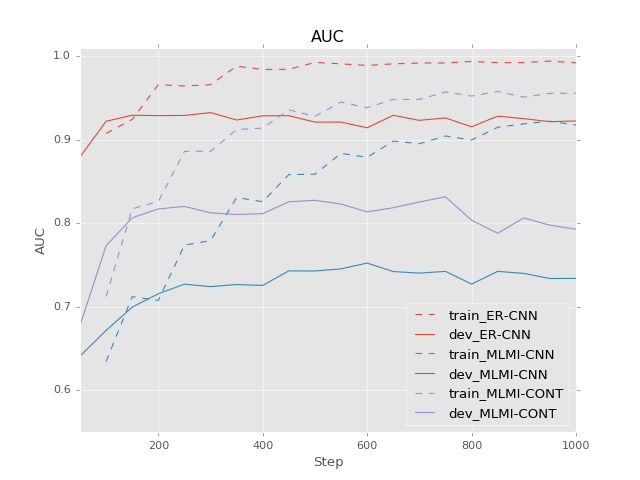

In [74]:
train_dirs = ['./train/1474149092', './train/1474179389', './train/1474062134']
colors = ['#E24A33', '#348ABD', '#988ED5']
models = ['ER-CNN', 'MLMI-CNN', 'MLMI-CONT']
fig_auc = plot_log(train_dirs, colors, models, 'auc', 
                   xlim=(50, 1000), ylim=(0.55, 1.01))
fig_auc.savefig(os.path.join(os.getcwd(), 'train', 'auc.pdf'))

<IPython.core.display.Javascript object>


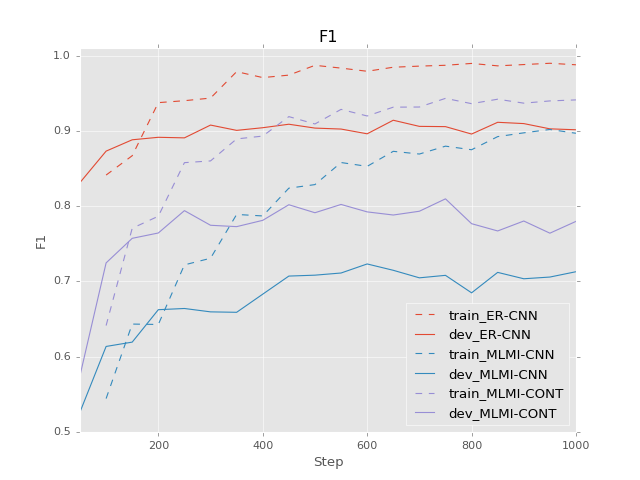

In [75]:
fig_f1 = plot_log(train_dirs, colors, models, 'f1', 
                  xlim=(50, 1000), ylim=(0.5, 1.01))
fig_f1.savefig(os.path.join(os.getcwd(), 'train', 'f1.pdf'))

<IPython.core.display.Javascript object>


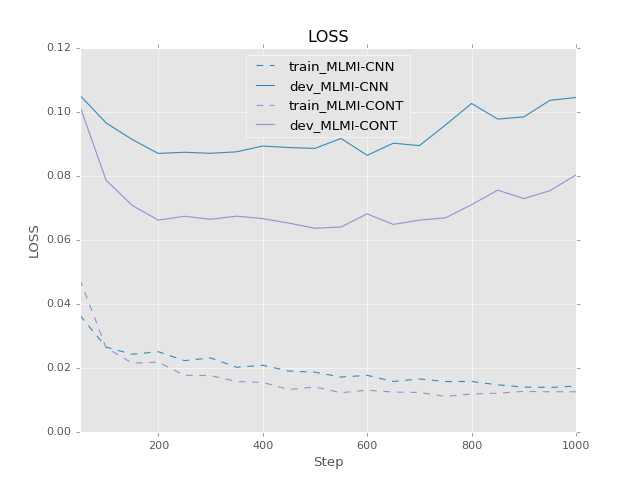

In [58]:
train_dirs = ['./train/1474179389', './train/1474062134']
colors = ['#348ABD', '#988ED5']
models = ['MLMI-CNN', 'MLMI-CONT']
fig_loss = plot_log(train_dirs, colors, models, 'loss')
fig_loss.savefig(os.path.join(os.getcwd(), 'train', 'loss.pdf'))